<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA
## Trábajo Práctico Nro. 4 
## Alumno: Ezequiel Alejandro Caamaño
## a1802

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install --upgrade numpy scipy
!pip install gensim --quiet

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 12.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 11.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.0 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
contourpy 1.

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [2]:
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)


In [4]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        output_sentence = output + ' <eos>'
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [7]:
def create_tokenizer(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer

input_tokenizer = create_tokenizer(input_sentences)
input_vocab_size = len(input_tokenizer.word_index) + 1
max_input_len = max([len(txt.split()) for txt in input_sentences])

output_tokenizer = create_tokenizer(output_sentences + output_sentences_inputs)
output_vocab_size = len(output_tokenizer.word_index) + 1
max_output_len = max([len(txt.split()) for txt in output_sentences])

word2idx_inputs = input_tokenizer.word_index
word2idx_outputs = output_tokenizer.word_index
num_words_output = output_vocab_size

print(f"Input vocab size: {input_vocab_size}")
print(f"Output vocab size: {output_vocab_size}")
print(f"Max input length: {max_input_len}")
print(f"Max output length: {max_output_len}")

encoder_input_sequences = input_tokenizer.texts_to_sequences(input_sentences)
decoder_input_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)
decoder_target_sequences = output_tokenizer.texts_to_sequences(output_sentences)

encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_output_len, padding='post')
decoder_targets = pad_sequences(decoder_target_sequences, maxlen=max_output_len, padding='post')

print(f"Encoder input shape: {encoder_input_sequences.shape}")
print(f"Decoder input shape: {decoder_input_sequences.shape}")
print(f"Decoder targets shape: {decoder_targets.shape}")

Input vocab size: 1800
Output vocab size: 1807
Max input length: 9
Max output length: 10
Encoder input shape: (6033, 9)
Decoder input shape: (6033, 10)
Decoder targets shape: (6033, 10)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [9]:

try:
    import gensim.downloader as api
    from gensim.models import FastText
    print("Gensim ya está instalado")
except ImportError:
    print("Instalando gensim...")
    !pip install gensim --quiet
    import gensim.downloader as api
    from gensim.models import FastText
    print("Gensim instalado exitosamente")

import numpy as np

def load_fasttext_embeddings():
    try:
        print("Descargando FastText embeddings pre-entrenados...")
        print("Esto puede tomar varios minutos la primera vez...")
        # Modelo FastText pre-entrenado en inglés
        fasttext_model = api.load('fasttext-wiki-news-subwords-300')
        print("FastText embeddings cargados exitosamente!")
        return fasttext_model, 300
    except Exception as e:
        print(f"Error descargando FastText: {e}")
        return None, None

def train_fasttext_from_scratch():
    print("Entrenando FastText desde cero con los datos del dataset...")

    sentences_for_training = []

    for sentence in input_sentences:
        sentences_for_training.append(sentence.split())

    for sentence in output_sentences:
        clean_sentence = sentence.replace('<eos>', '').replace('<sos>', '').strip()
        if clean_sentence:
            sentences_for_training.append(clean_sentence.split())

    fasttext_model = FastText(
        sentences=sentences_for_training,
        vector_size=100,  
        window=5,         
        min_count=1,      
        workers=4,        
        sg=1,             
        epochs=20         
    )

    print(f"FastText entrenado con {len(sentences_for_training)} oraciones")
    print(f"Vocabulario: {len(fasttext_model.wv.key_to_index)} palabras")

    return fasttext_model, 100

print("Opciones de FastText:")
print("1. Usar FastText pre-entrenado (300D) - Mejor calidad pero descarga grande")
print("2. Entrenar FastText desde cero (100D) - Más rápido, específico para tus datos")
print("3. Usar embeddings entrenables simples - Más rápido para pruebas")

use_option = 2 

if use_option == 1:
    print("Seleccionado: FastText pre-entrenado")
    fasttext_model, embedding_dim = load_fasttext_embeddings()
    if fasttext_model is None:
        print("Fallback: Entrenando FastText desde cero...")
        fasttext_model, embedding_dim = train_fasttext_from_scratch()
elif use_option == 2:
    print("Seleccionado: FastText desde cero")
    fasttext_model, embedding_dim = train_fasttext_from_scratch()
else:
    print("Seleccionado: Embeddings entrenables simples")
    fasttext_model, embedding_dim = None, 100

def create_fasttext_embedding_matrix(word_index, fasttext_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    words_found = 0

    for word, i in word_index.items():
        try:
            embedding_vector = fasttext_model.wv[word]
            embedding_matrix[i] = embedding_vector
            words_found += 1
        except KeyError:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)

    print(f"Palabras encontradas en FastText: {words_found}/{len(word_index)}")
    return embedding_matrix

if fasttext_model is not None:
    print("Creando matrices de embedding con FastText...")
    encoder_embedding_matrix = create_fasttext_embedding_matrix(
        word2idx_inputs, fasttext_model, embedding_dim)
    decoder_embedding_matrix = create_fasttext_embedding_matrix(
        word2idx_outputs, fasttext_model, embedding_dim)

    print(f"Encoder embedding matrix shape: {encoder_embedding_matrix.shape}")
    print(f"Decoder embedding matrix shape: {decoder_embedding_matrix.shape}")

    use_pretrained_embeddings = True
else:
    print("Usando embeddings entrenables simples")
    embedding_dim = 100
    use_pretrained_embeddings = False

print(f"Embedding dimension: {embedding_dim}")
print(f"Using pretrained embeddings: {use_pretrained_embeddings}")

Gensim ya está instalado
Opciones de FastText:
1. Usar FastText pre-entrenado (300D) - Mejor calidad pero descarga grande
2. Entrenar FastText desde cero (100D) - Más rápido, específico para tus datos
3. Usar embeddings entrenables simples - Más rápido para pruebas
Seleccionado: FastText desde cero
Entrenando FastText desde cero con los datos del dataset...
FastText entrenado con 12016 oraciones
Vocabulario: 2160 palabras
Creando matrices de embedding con FastText...
Palabras encontradas en FastText: 1799/1799
Palabras encontradas en FastText: 1806/1806
Encoder embedding matrix shape: (1800, 100)
Decoder embedding matrix shape: (1807, 100)
Embedding dimension: 100
Using pretrained embeddings: True


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [10]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

latent_dim = 256
embedding_dim = 100

# ENCODER
encoder_inputs = Input(shape=(max_input_len,), name='encoder_inputs')
encoder_embedding = Embedding(input_vocab_size,
                            embedding_dim,
                            input_length=max_input_len,
                            trainable=True,
                            name='encoder_embedding')(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# DECODER
decoder_inputs = Input(shape=(max_output_len,), name='decoder_inputs')
decoder_embedding_layer = Embedding(output_vocab_size,
                                   embedding_dim,
                                   input_length=max_output_len,
                                   trainable=True,
                                   name='decoder_embedding')
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(output_vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

decoder_targets_reshaped = np.expand_dims(decoder_targets, -1)

X_train_enc, X_val_enc, X_train_dec, X_val_dec, y_train, y_val = train_test_split(
    encoder_input_sequences, decoder_input_sequences, decoder_targets_reshaped,
    test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_enc)}")
print(f"Validation samples: {len(X_val_enc)}")

print("Iniciando entrenamiento...")
history = model.fit([X_train_enc, X_train_dec], y_train,
                   batch_size=32,  
                   epochs=50,     
                   validation_data=([X_val_enc, X_val_dec], y_val),
                   verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 9, 100)    │    180,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 10, 100)   │    180,700 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    365,568 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 10, 256), │    365,568 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 10, 1807)  │    464,399 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,556,235 (5.94 MB)

 Trainable params: 1,556,235 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

None
Training samples: 4826
Validation samples: 1207
Iniciando entrenamiento...
Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5226 - loss: 3.6691 - val_accuracy: 0.6395 - val_loss: 2.1019
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6531 - loss: 1.9428 - val_accuracy: 0.6840 - val_loss: 1.8648
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6939 - loss: 1.7173 - val_accuracy: 0.7105 - val_loss: 1.7185
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7179 - loss: 1.5661 - val_accuracy: 0.7205 - val_loss: 1.6267
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7282 - loss: 1.4689 - val_accuracy: 0.7324 - val_loss: 1.5715
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7417 - loss: 1.3607 - val_accuracy: 0.7390 - val_loss: 1.5300
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7429 - loss: 1.3236 - val_accuracy: 0.7399 - val_loss: 1.5112
Epoch 8/50
151/151 

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

Entrenamiento completado!


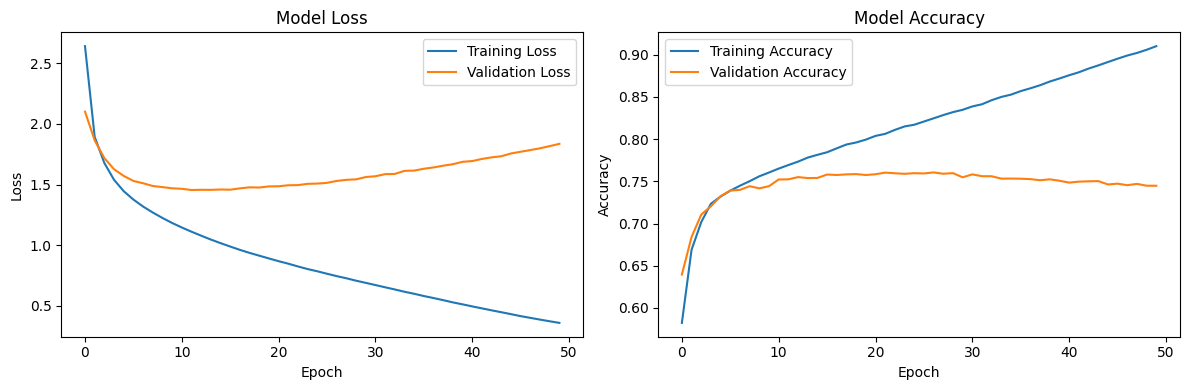

Evaluando el modelo con ejemplos del dataset:
------------------------------------------------------------
Entrada: hello 
Esperado: hi how are you
Predicho: hello how are you
------------------------------------------------------------
Entrada: hi how are you 
Esperado: not bad and you
Predicho: i m good how are you
------------------------------------------------------------
Entrada: hi 
Esperado: hello
Predicho: hi
------------------------------------------------------------
Entrada: hi 
Esperado: hello
Predicho: hi
------------------------------------------------------------
Entrada: hi 
Esperado: hello how are you today
Predicho: hi
------------------------------------------------------------
Entrada: where are you working 
Esperado: bro
Predicho: bro
------------------------------------------------------------
Entrada: bro 
Esperado: where are you from
Predicho: how are you
------------------------------------------------------------
Entrada: where are you from 
Esperado: i am fr

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,), name='decoder_inputs_single')
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model = Model([decoder_inputs_single] + decoder_states_inputs,
                     [decoder_outputs_inf] + decoder_states_inf)

reverse_input_char_index = dict((i, char) for char, i in word2idx_inputs.items())
reverse_target_char_index = dict((i, char) for char, i in word2idx_outputs.items())

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1))
    if '<sos>' in word2idx_outputs:
        target_seq[0, 0] = word2idx_outputs['<sos>']
    else:
        target_seq[0, 0] = 1

    decoded_sentence = ''
    max_decoder_seq_length = max_output_len

    for _ in range(max_decoder_seq_length):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index in reverse_target_char_index:
            sampled_char = reverse_target_char_index[sampled_token_index]

            if sampled_char == '<eos>':
                break

            if sampled_char not in ['<sos>', '<eos>', '<pad>']:
                decoded_sentence += sampled_char + ' '

        if sampled_token_index == 0:
            break

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence.strip()

def clean_response(response):
    """
    Limpia la respuesta eliminando tokens especiales y múltiples espacios
    """
    special_tokens = ['<eos>', '<sos>', '<pad>', 'eos', 'sos', 'pad']

    for token in special_tokens:
        response = response.replace(token, '')

    response = ' '.join(response.split())

    return response.strip()

def chat_with_bot(input_text):
    input_text = clean_text(input_text)

    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    decoded_sentence = decode_sequence(input_seq)

    cleaned_response = clean_response(decoded_sentence)

    return cleaned_response

def evaluate_model():
    print("Evaluando el modelo con ejemplos del dataset:")
    print("-" * 60)

    for i in range(min(10, len(input_sentences))):
        input_example = input_sentences[i]
        # Limpiar la salida esperada de tokens especiales
        expected_output = clean_response(output_sentences[i].replace(' <eos>', ''))
        predicted_output = chat_with_bot(input_example)

        print(f"Entrada: {input_example}")
        print(f"Esperado: {expected_output}")
        print(f"Predicho: {predicted_output}")
        print("-" * 60)

def test_bot():
    print("Bot QA está listo! Escribe 'quit' para salir.")
    print("-" * 50)

    while True:
        user_input = input("Tú: ")
        if user_input.lower() == 'quit':
            print("¡Hasta luego!")
            break

        response = chat_with_bot(user_input)
        print(f"Bot: {response}")
        print("-" * 50)

import matplotlib.pyplot as plt

def plot_training_history():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Entrenamiento completado!")
plot_training_history()
evaluate_model()

test_bot()

### Conclusiones

Se probaron diferentes opciones pero la única que funcionó correctamente fue usar FastText, entrenando desde cero. Otro punto interesante es que se observa como las métricas de perdida y accuracy se separan de tal manera que podemos observar que probablemente se estén entrenando demasiadas epocas para el set de datos y estamos ante la presencia clara de overfitting.
No obstante, los resultados obtenidos son bastante aceptables y una mejora se podría lograr al ajustar los parametros mencionados y otros. 
Nota: Se intentó ejecutar las celdas de la notebook para poder probar con la reducción de las épocas y otras modificaciones y rompía el flujo al instalar gensim. Por lo que nos quedamos con los resultados obtenidos hasta el momento. 